# Thanks Recipient Experiment Survival Analysis Exploration
[J. Nathan Matias](https://github.com/natematias)
February 2019

The purpose of this code is to conduct preliminary survival analyses of the data for CivilServant's research with Thanks Recipients. This code uses [historical data prepared by Max Klein](https://docs.google.com/document/d/1RKJZqoWKQuWDoKk94drIEsJWK6kBUeZ8KIJOyEqDTTE/edit). The analyses in this code will inform power analysis and study design in CivilServant's research with Wikipedians on [the effects of giving thanks to other Wikipedians](https://meta.wikimedia.org/wiki/Research:Testing_capacity_of_expressions_of_gratitude_to_enhance_experience_and_motivation_of_editors):
* The experiment plan is on Overleaf: [Experiment Plan: Mentoring and Protection in Wikipedia Moderation](https://www.overleaf.com/project/5c379e06f882d02f5b8c9f44)

**Note:** Since the thanks recipient study will involve participants on multiple language Wikipedias, this code defines a procedure that can be reproduced for the following language wikipedias:
* German
* Persian
* Arabic
* Plish

# Load Libraries

In [60]:
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)
library(ggplot2)
library(rlang)


library(survminer)
library(survival)
## ^^ documentation: https://cran.r-project.org/web/packages/survminer/vignettes/Informative_Survival_Plots.html

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] survival_2.43-3 survminer_0.4.3 ggpubr_0.2      magrittr_1.5   
[5] rlang_0.3.0.1   ggplot2_3.1.0   MASS_7.3-51.1   dplyr_0.7.8    

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.0        pillar_1.3.0      compiler_3.5.1    plyr_1.8.4       
 [5] bindr_0.1.1       base64enc_0.1-3   too

# Load Power Analysis Dataframes

In [61]:
eligible.rows <- function(df.to.review){
    print(      "========================")
    print(paste("Subset Variables For:", unique(df.to.review$lang)))
    print(      "========================")
    cat("\n")
    
    # VARIABLE: experience_level_pre_treatment: Definition: 
    #  the elapsed number of days between registration 
    #  and last edit in the observation period up to the simulated treatment date

    df.to.review$prev_experience <- as.integer(gsub("bin_", "", df.to.review$experience_level_pre_treatment))
    df.to.review$prev_experience <- factor(df.to.review$prev_experience, 
                                          levels = sort(unique(df.to.review$prev_experience)))
    
    df.to.review$num_prev_thanks_pre_treatment <- df.to.review$num_prev_thanks_before_treatment

    ## BECAUSE THIS DATASET INCLUDES INACTIVE EDITORS
    ## WE REDUCE THE DATASET ONLY TO EDITORS ACTIVE IN THE LAST 90 DAYS
    print(paste("Number of rows before removing inactive users:", nrow(df.to.review)))
    df.to.review <- subset(df.to.review, num_edits_90_pre_treatment > 0 )
    print(paste("Number of rows after removing inactive users:", nrow(df.to.review)))
    cat("\n")

    df.to.review    
}

In [62]:
data.path <- "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/datasets/power_analysis"
de.power.df <- eligible.rows(read.csv(file.path(data.path, "de_gratitude_power-analysis_dataset_sim_date_20180306_v1.csv")))
fa.ar.pl.power.df <- read.csv(file.path(data.path, "gratitude_power-analysis_dataset_sim_date_20180306_v1.csv"))
fa.power.df <- eligible.rows(subset(fa.ar.pl.power.df, lang=="fa"))
ar.power.df <- eligible.rows(subset(fa.ar.pl.power.df, lang=="ar"))
pl.power.df <- eligible.rows(subset(subset(fa.ar.pl.power.df, lang=="fa")))

simulated.treatment.date <- as.Date("20180306", "%Y%M%D")

[1] "========================"
[1] "Subset Variables For: de"
[1] "========================"

[1] "Number of rows before removing inactive users: 1800"
[1] "Number of rows after removing inactive users: 900"

[1] "========================"
[1] "Subset Variables For: fa"
[1] "========================"

[1] "Number of rows before removing inactive users: 2844"
[1] "Number of rows after removing inactive users: 1600"

[1] "========================"
[1] "Subset Variables For: ar"
[1] "========================"

[1] "Number of rows before removing inactive users: 2875"
[1] "Number of rows after removing inactive users: 1600"

[1] "========================"
[1] "Subset Variables For: fa"
[1] "========================"

[1] "Number of rows before removing inactive users: 2844"
[1] "Number of rows after removing inactive users: 1600"



# Construct and Review an Account-Period Dataset for Survival Analysis

In [63]:
initialize_account.periods.df <- function(){
    account.periods.df <- data.frame(
        user_id                       = NA,
        user_registration             = NA,
        lang                          = NA,
        prev_experience               = NA,
        active_in_30_pre_treatment    = NA,
        num_prev_thanks_pre_treatment = NA,
        num_edits_90_pre_treatment    = NA,
        labour_hours_90_pre_treatment = NA,
        week                          = NA,
        num_edits                     = NA,
        any_edits                     = NA,
        labor_hours                   = NA,
        inactive                      = NA
    )
    account.periods.df
}

# Create a person period dataset from a single row of the power analysis data
#
#` @param row The row to convert into a series of rows
create.person.period.rows <- function(row){

    ## we use the definition that someone is active
    ## if they edited at least once in a one-month period
    ## this is why we rate active-ness as "was active in
    ## the four week period after the beginning of this week"
    last.person.period.week = 8

    num.edit.post.treat.keys = c()
    labor.hours.post.treat.keys = c()

    for(i in seq(1,12)){
        num.edit.post.treat.keys <- append(num.edit.post.treat.keys,
                                           paste("num_edits_week_",i,"_post_treatment", sep=""))
        labor.hours.post.treat.keys <- append(num.edit.post.treat.keys,
                                           paste("labor_hours_week_",i,"_post_treatment", sep=""))
    }

    account.periods.df <- initialize_account.periods.df()

    ## iterate backward from the 12th week
    ## and set still.active to true from the
    ## last week that we observe activity in the account
    still.active <- FALSE
    for(i in seq(12,1)){
        num.edit.key = num.edit.post.treat.keys[i]
        labor.hours.key = labor.hours.post.treat.keys[i]

        if(still.active == FALSE){
            if(row[[num.edit.key]] > 0){
                still.active = TRUE
            }
        }

        inactive <- NA
        if(i<=last.person.period.week){
            inactive <- still.active != TRUE
        }
        #print(paste("week: ", i,", inactive: ", inactive, ", still.active: ", still.active, sep=""))
        
        ## If the account is 

        row.df <- data.frame(
            user_id                       = row$user_id,
            user_registration             = as.Date(toString(row$user_registration)),
            lang                          = toString(row$lang),
            prev_experience               = as.integer(toString(row$prev_experience)),
            active_in_30_pre_treatment    = row$active_in_30_pre_treatment,
            num_prev_thanks_pre_treatment = row$num_prev_thanks_pre_treatment,
            num_edits_90_pre_treatment    = row$num_edits_90_pre_treatment,
            labour_hours_90_pre_treatment = row$labour_hours_90_pre_treatment,
            week                          = i,
            num_edits                     = row[[num.edit.key]],
            any_edits                     = row[[num.edit.key]] > 0,
            labor_hours                   = row[[labor.hours.key]],
            inactive                      = as.integer(inactive)
        )
        account.periods.df <- rbind(account.periods.df, row.df)
    }

    account.periods.df <- subset(account.periods.df, is.na(user_id)!=TRUE)
    account.periods.df
}

# Make a test row's edits and labor hours over N weeks blank
#
#` @row The row to make blank
create.blank.test.row <- function(row){
    for(i in seq(1,12)){
        row[paste("num_edits_week_",i,"_post_treatment", sep="")] <- 0
        row[paste("any_edits_week_",i,"_post_treatment", sep="")] <- FALSE
        row[paste("labor_hours_week_",i,"_post_treatment", sep="")] <- 0
        row[paste("any_labor_hours_week_",i,"_post_treatment", sep="")] <- FALSE

    }
    
    for(i in seq(1,12)){
    }
    row
}

#### Test Cases
* no edits at any time
* edits in the last week
* edits in the 7th week

In [64]:
## initialize test DF
test.account.df <- de.power.df[1,]
test.account.df <- create.blank.test.row(test.account.df[1,])

## CASE: NO EDITS AT ANY TIME
test.ap.df <- create.person.period.rows(test.account.df)

print("Testing creation of account period datasets")
print("-------------------------------------------")
cat("\n")

# expect: 0 weeks active
print("expects 0 weeks:")
print(paste(nrow(subset(test.ap.df, inactive==0)), "weeks active")) 

## CASE: 1 EDIT IN 12th WEEK
test.account.df['num_edits_week_12_post_treatment']  = 1
test.account.df['labor_hours_week_12_post_treatment']  = 1
test.ap.df <- create.person.period.rows(test.account.df)
# expect: 8 weeks active
print("expects 8 weeks:")
print(paste(nrow(subset(test.ap.df, inactive==0)), "weeks active")) 
cat("\n")

## CASE: 1 EDIT IN 9th WEEK
test.account.df <- create.blank.test.row(test.account.df[1,])
test.account.df['num_edits_week_9_post_treatment']  = 1
test.account.df['labor_hours_week_9_post_treatment']  = 1
test.ap.df <- create.person.period.rows(test.account.df)
# expect: 8 weeks active
print("expects 8 weeks:")
print(paste(nrow(subset(test.ap.df, inactive==0)), "weeks active")) 
cat("\n")


## CASE: 1 EDIT IN 8th WEEK
test.account.df <- create.blank.test.row(test.account.df[1,])
test.account.df['num_edits_week_8_post_treatment']  = 1
test.account.df['labor_hours_week_8_post_treatment']  = 1
test.ap.df <- create.person.period.rows(test.account.df)
# expect: 8 weeks active
print("expects 8 weeks:")
print(paste(nrow(subset(test.ap.df, inactive==0)), "weeks active")) 
cat("\n")

## CASE: 1 EDIT IN 6th WEEK
test.account.df <- create.blank.test.row(test.account.df[1,])
test.account.df['num_edits_week_6_post_treatment']  = 1
test.account.df['labor_hours_week_6_post_treatment']  = 1
test.ap.df <- create.person.period.rows(test.account.df)
# expect: 6 weeks active
print("expects 6 weeks:")
print(paste(nrow(subset(test.ap.df, inactive==0)), "weeks active")) 
cat("\n")

[1] "Testing creation of account period datasets"
[1] "-------------------------------------------"

[1] "expects 0 weeks:"
[1] "0 weeks active"
[1] "expects 8 weeks:"
[1] "8 weeks active"

[1] "expects 8 weeks:"
[1] "8 weeks active"

[1] "expects 8 weeks:"
[1] "8 weeks active"

[1] "expects 6 weeks:"
[1] "6 weeks active"



### Generate an Account Period Dataframe

In [65]:
# generate.account.period.dataframe
# Create an account period dataframe from a power analysis dataframe
# ` 
# `@power.df power analysis dataframe
generate.account.period.dataframe <- function(power.df){
    print(paste("Generating account period dataframe for", unique(power.df$lang)))
    account.periods.df <- initialize_account.periods.df()
    for(i in seq(1,nrow(power.df))){
        if(i %% 100 == 0){
            cat(".")
            flush.console()
        }
        row = power.df[i,]
        account.period.df  <- create.person.period.rows(row)
        account.periods.df <- rbind(account.periods.df, account.period.df)
    }
    cat("\n")
    account.periods.df <- subset(account.periods.df, is.na(user_id)!=TRUE)
    print(paste("Number of participants: ", nrow(power.df), sep=""))
    print(paste("Number of account periods: ", nrow(account.periods.df), sep="")) 
    print(paste("Number periods per account: ", nrow(account.periods.df) / nrow(power.df)), sep="")
    account.periods.df
}

In [67]:
de.account.periods.df <- generate.account.period.dataframe(de.power.df)
cat("\n")
fa.account.periods.df <- generate.account.period.dataframe(fa.power.df)
cat("\n")
ar.account.periods.df <- generate.account.period.dataframe(ar.power.df)
cat("\n")
pl.account.periods.df <- generate.account.period.dataframe(pl.power.df)

[1] "Generating account period dataframe for de"
.........
[1] "Number of participants: 900"
[1] "Number of account periods: 10800"
[1] "Number periods per account:  12"

[1] "Generating account period dataframe for fa"
................
[1] "Number of participants: 1600"
[1] "Number of account periods: 19200"
[1] "Number periods per account:  12"

[1] "Generating account period dataframe for ar"
................
[1] "Number of participants: 1600"
[1] "Number of account periods: 19200"
[1] "Number periods per account:  12"

[1] "Generating account period dataframe for fa"
................
[1] "Number of participants: 1600"
[1] "Number of account periods: 19200"
[1] "Number periods per account:  12"


# Generate Survival Analysis 

In [85]:
generate.survival.analysis <- function(account.periods.df, lang){
    print(paste("Survival Analysis for", unique(account.periods.df$lang)))
    print(paste("------------------------"))
    cat("\n")

    print(paste("Information for Deciding on Prev Active Cutoff:", unique(account.periods.df$lang)))
    print(paste("Active 90 days prev % inactive by week eight:", 
            prettyNum(mean(subset(account.periods.df, week==8)$inactive)*100)))
    print(paste("Active 30 days prev % inactive by week eight:", 
                prettyNum(mean(subset(account.periods.df, active_in_30_pre_treatment=="True" & week==8)$inactive)*100)))
    print(paste("Active 90 days but Inactive 30 days prev % inactive by week eight:", 
        prettyNum(mean(subset(account.periods.df, active_in_30_pre_treatment=="False" & week==8)$inactive)*100)))
    cat("\n")
    
    ## define newcomer as an account that has 0 previous experience
    ## (note: in the full study, we're going to drop anyone with fewer than 3 edits)
    account.periods.df$newcomer <- account.periods.df$prev_experience== 0
    
#     print("Base Survival Model Results")
#     account.survival.fit <- survfit(Surv(week, inactive) ~ 1, data=account.periods.df)
#     ## we expect weeks over 8 to be removed for NAs
#     print(summary(account.survival.fit))
#     cat("\n")
    
    print("Base Logistic Regression Results")
    print(summary(glm(inactive ~ week, 
                      data = account.periods.df, 
                      family=binomial)))
    cat("\n")

#     print("Newcomer Survival Model Results")
#     account.periods.df$newcomer <- account.periods.df$prev_experience== 0 
#     account.survival.fit <- survfit(Surv(week, inactive) ~ newcomer, data=account.periods.df)
#     ## we expect weeks over 8 to be removed for NAs
#     print(summary(account.survival.fit))
#     cat("\n")    
    
    print("Newcomer Logistic Regression Results")
    print(summary(glm(inactive ~ week, 
                      data = subset(account.periods.df, newcomer == TRUE), 
                      family=binomial)))
    cat("\n")

    print("Experienced Logistic Regression Results")
    print(summary(glm(inactive ~ week, 
                      data = subset(account.periods.df, newcomer == FALSE), 
                      family=binomial)))
    cat("\n")
    
    ## CREATE DATAFRAME OF INACTIVE IN THE FIRST FOUR WEEKS
    
    data.frame(
        lang = lang,
        experience = c("newcomer", "newcomer", "newcomer", "newcomer",
                       "experienced", "experienced", "experienced", "experienced"),
        week = c(1,2,3,4,1,2,3,4),
        active = c(
            nrow(subset(account.periods.df, prev_experience == 0 & week == 1 & inactive == FALSE)) / nrow(subset(de.account.periods.df, prev_experience == 0 & week == 1)),
            nrow(subset(account.periods.df, prev_experience == 0 & week == 2 & inactive == FALSE)) / nrow(subset(de.account.periods.df, prev_experience == 0 & week == 2)),        
            nrow(subset(account.periods.df, prev_experience == 0 & week == 3 & inactive == FALSE)) / nrow(subset(de.account.periods.df, prev_experience == 0 & week == 3)),        
            nrow(subset(account.periods.df, prev_experience == 0 & week == 4 & inactive == FALSE)) / nrow(subset(de.account.periods.df, prev_experience == 0 & week == 4)),        
            nrow(subset(account.periods.df, prev_experience >  0 & week == 1 & inactive == FALSE)) / nrow(subset(de.account.periods.df, prev_experience >  0 & week == 1)),
            nrow(subset(account.periods.df, prev_experience >  0 & week == 2 & inactive == FALSE)) / nrow(subset(de.account.periods.df, prev_experience >  0 & week == 2)),        
            nrow(subset(account.periods.df, prev_experience >  0 & week == 3 & inactive == FALSE)) / nrow(subset(de.account.periods.df, prev_experience >  0 & week == 3)),        
            nrow(subset(account.periods.df, prev_experience >  0 & week == 4 & inactive == FALSE)) / nrow(subset(de.account.periods.df, prev_experience >  0 & week == 4))        
        )
    )
    
}

In [108]:
survival.tables <- generate.survival.analysis(de.account.periods.df, "de")
survival.tables <- rbind(survival.tables, generate.survival.analysis(fa.account.periods.df, "fa"))
survival.tables <- rbind(survival.tables, generate.survival.analysis(ar.account.periods.df, "ar"))
survival.tables <- rbind(survival.tables, generate.survival.analysis(pl.account.periods.df, "pl"))

[1] "Survival Analysis for de"
[1] "------------------------"

[1] "Information for Deciding on Prev Active Cutoff: de"
[1] "Active 90 days prev % inactive by week eight: 80.22"
[1] "Active 30 days prev % inactive by week eight: 68.86"
[1] "Active 90 days but Inactive 30 days prev % inactive by week eight: 89.78"

[1] "Base Logistic Regression Results"

Call:
glm(formula = inactive ~ week, family = binomial, data = account.periods.df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.794  -1.493   0.727   0.823   0.891  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.6222     0.0572   10.87  < 2e-16 ***
week          0.0956     0.0118    8.07  7.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 8266.6  on 7199  degrees of freedom
Residual deviance: 8200.8  on 7198  degrees of freedom
  (3600 observations deleted due to missingness

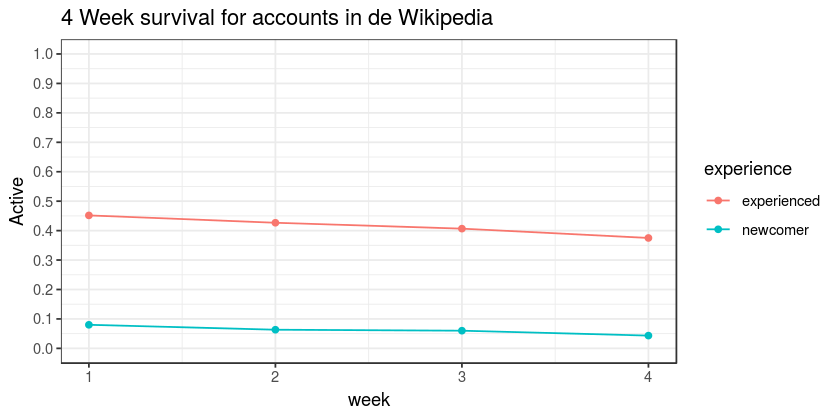

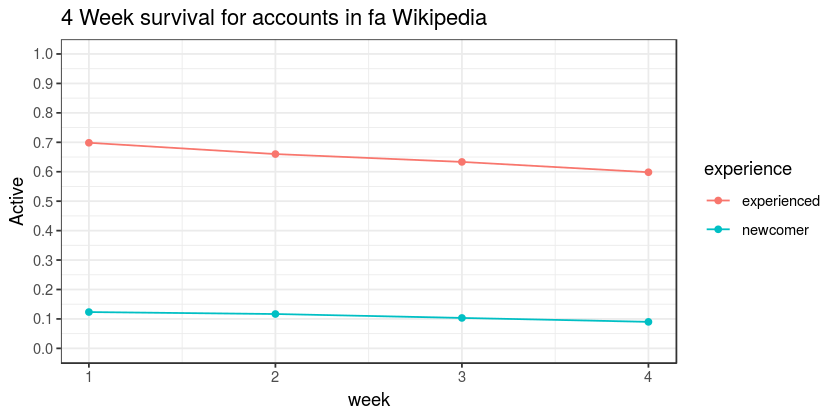

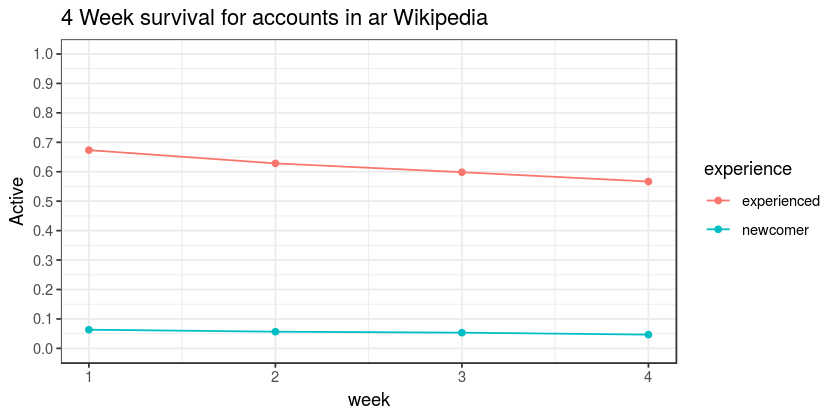

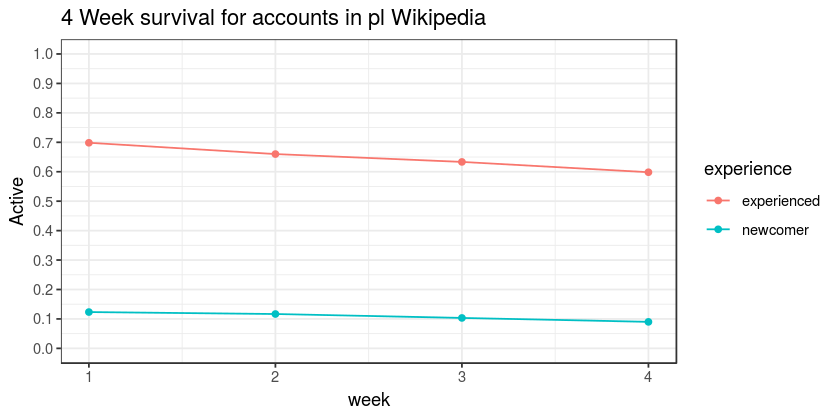

In [116]:
for(language in unique(survival.tables$lang)){
    survival.table <- subset(survival.tables, lang==language)
    p <- ggplot(survival.table, (aes(week, active, color=experience))) +
         geom_line() +
         geom_point() +
         scale_y_continuous(name="Active", breaks=seq(0,1,0.1), limits=c(0,1)) +
         theme_bw() + 
         ggtitle(paste("4 Week survival for accounts in", language, "Wikipedia"))
    print(p)
}

### Write Survival Tables

In [112]:
write.csv(survival.tables, file="fa.ar.pl.de.20180306.survival.tables.csv")